### This notebook defines and text the custom implementation for the explainability model:
## Likelihood importance

In [1]:
# Imports
import pandas as pd
from typing import List

from tqdm import tqdm
from collections import OrderedDict
from termcolor import colored
import torch
from torch.jit import RecursiveScriptModule


# other libraries
from typing import Final

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:

# own modules
from src.model_utils import load_model
from src.model_utils import predict_single_text
from src.model_utils import load_w2v_model
from src.model_utils import set_seed
from src.RNNModelTrain.data import tokenize_sentence


In [3]:
# static variables
DATA_PATH: Final[str] = "NLP_Data/data"
MODEL_TYPE: Final[str] = "IMDB"  # "TweepFake"

# set device
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
set_seed(42)

In [4]:
# load the model
if MODEL_TYPE == "IMDB":
    model: RecursiveScriptModule = load_model("IMDB_best_model")
else:
    model: RecursiveScriptModule = load_model("best_model")
    
# Load the w2v model
w2vec_model = load_w2v_model()

In [5]:
if MODEL_TYPE == "IMDB":
    file_path = DATA_PATH + '/test.txt'
    data: pd.DataFrame = pd.read_csv(file_path, sep='\t', header=None)
    data.columns = ['text', 'tag']

else:
    file_path = DATA_PATH + '/test.csv'
    data: pd.DataFrame = pd.read_csv(file_path)

    # replace the target column with a binary representation
    data['tag'] = data['account.type'].replace('human', 0)
    data['tag'] = data['tag'].replace('bot', 1)
    # Only keep columns text and tag
    data = data[['text', 'tag']]

print(data.head())

                                                text  tag
0  I first saw The Buddy Holly Story when I was a...    1
1  There were so many things wrong with this movi...    0
2  There's a unique place in the pantheon of John...    1
3  It kicks you in the stomach. There are other f...    1
4  To start, I'm not a person to rate movies that...    0


In [6]:
# Test the model with a single text
text = data['text'][2]
print(text)
predicted = predict_single_text(text, model, device)
print(f"Predicted: {predicted}, Real: {data['tag'][0]}")

There's a unique place in the pantheon of John Ford films for Wagonmaster, Sergeant Rutledge, and The Sun Shines Bright. It was these three films with no box office names in them that Ford didn't have to tailor the film around the persona of a star being it John Wayne, Henry Fonda, or any of the others he worked with. Not surprising that Ford considered all these as favorites of one kind or another. <br /><br />Ben Johnson and Harry Carey, Jr. a couple of likable cowpokes sign on to guide a Mormon wagon train to a valley in Arizona territory. Along the way they are joined first by a group stranded players from a medicine show and then by a family of outlaws on the run named Clegg. Their stories merge and what happens is the basis of the film's plot.<br /><br />Had Wagonmaster been done even 10 years earlier on the strength of the two performances turned in by Johnson and Carey, both probably would have had substantial careers as B picture cowboys. In the case of Johnson it would have b

c:\Users\pablo\Desktop\IMAT\Tercero\NaturalLanguageProcessing\rnn_explainability\env\lib\site-packages\torch\nn\modules\module.py:1520: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  return forward_call(*args, **kwargs)


In [7]:
def likelihood_permutation_importance(text: str, model: torch.nn.Module, device: torch.device = device) -> dict:
    """
    This function calculates the likelihood permutation importance of each word in the text.

    Args:
        text: Text to calculate the likelihood permutation importance.
        model: Model to use for the predictions.
        device: Device to use for the predictions.

    Returns:
        A dictionary with the likelihood permutation importance of each word in the text.
    """
    
    # tokenize the text
    tokenized_text: List[str] = tokenize_sentence(text)
    
    # get the real class
    original_prediction: float = predict_single_text(text, model, device, probability=False, likelihood=True)

    # Initialize permutation importance dictionary
    permutation_importance: dict = {}

    # Iterate over each token (word) in the text
    for i, token in enumerate(tqdm(tokenized_text, desc="Calculating permutation importance")):
        # Initialize importance for current token
        token_importance: float = 0

        # Iterate over each possible position for the current token
        for j in range(len(tokenized_text)):
            if j != i:
                # Create a copy of tokens with the current token moved to position j
                shuffled_tokens: List[str] = tokenized_text.copy()
                shuffled_tokens.pop(i)
                shuffled_tokens.insert(j, token)

                # Join the shuffled tokens back into a text
                shuffled_text = ' '.join(shuffled_tokens)

                # Get the predictions of the shuffled text
                shuffled_predictions: float = predict_single_text(shuffled_text, model, device, probability=False, likelihood=True)

                # Accumulate the importance of moving the current token to position j
                token_importance += shuffled_predictions - original_prediction

        # Store the total importance for the current token
        permutation_importance[token] = token_importance

    return permutation_importance



In [8]:
def plot_importance(perm_importance: dict, title: str):
    """
    Plots the permutation importance of each word in a text.

    Args:
        perm_importance: A dictionary with the permutation importance of each word in the text.
        title: The title of the plot.
    """
    # Sort the permutation importance by value
    perm_importance = OrderedDict(sorted(perm_importance.items(), key=lambda x: x[1], reverse=True))
    
    #Select the top 10 and bottom 10 words if the text is longer than 20 words
    if len(perm_importance) > 20:
        perm_importance = dict(list(perm_importance.items())[:10] + list(perm_importance.items())[-10:])
        perm_importance['...'] = 0
        perm_importance = OrderedDict(sorted(perm_importance.items(), key=lambda x: x[1], reverse=True))

    # Create a dataframe from the permutation importance
    df = pd.DataFrame(list(perm_importance.items()), columns=['Word', 'Importance'])
    
    # Set the color of the bars based on the importance value
    colors = ['red' if imp < 0 else 'blue' for imp in df['Importance']]
    
    # Plot the permutation importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Word', data=df, palette=colors)
    plt.title(title)
    plt.show()


In [10]:
# Now we will test the new method with a text
"""text = data['text'][2]
print(f"Explaining result for: {text}")
result = likelihood_permutation_importance(text, model)
print(result)"""
# The computation of the permutation importance can take a long time for long texts. 
# Hence, it is not viable to process this one

'text = data[\'text\'][2]\nprint(f"Explaining result for: {text}")\nresult = likelihood_permutation_importance(text, model)\nprint(result)'

In [11]:
# plot_importance(result, "Permutation Importance of each word in the text")

In [12]:
# Now we will test the new method with a text
text = "This movie is the best to make me fall asleep. The actors are boring and the story is terrible."
print(f"Explaining result for: {text}")
result = likelihood_permutation_importance(text, model)
print(result)

c:\Users\pablo\Desktop\IMAT\Tercero\NaturalLanguageProcessing\rnn_explainability\env\lib\site-packages\torch\nn\modules\module.py:1520: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  return forward_call(*args, **kwargs)


Explaining result for: This movie is the best to make me fall asleep. The actors are boring and the story is terrible.


Calculating permutation importance: 100%|██████████| 19/19 [00:00<00:00, 19.15it/s]

{'This': -0.2852781265974045, 'movie': 0.6799236796796322, 'is': 1.7602088004350662, 'the': 0.6214919090270996, 'best': -0.00284460186958313, 'to': 0.0, 'make': 0.2863539904356003, 'me': 0.35780927538871765, 'fall': 0.1493554711341858, 'asleep': 0.131251260638237, 'The': 0.14464694261550903, 'actors': 0.4126390963792801, 'are': 0.20403854548931122, 'boring': -0.23779547214508057, 'and': 0.0, 'story': 1.1957293301820755, 'terrible': 2.3822730481624603}


C:\Users\pablo\AppData\Local\Temp\ipykernel_17664\2793492178.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Word', data=df, palette=colors)


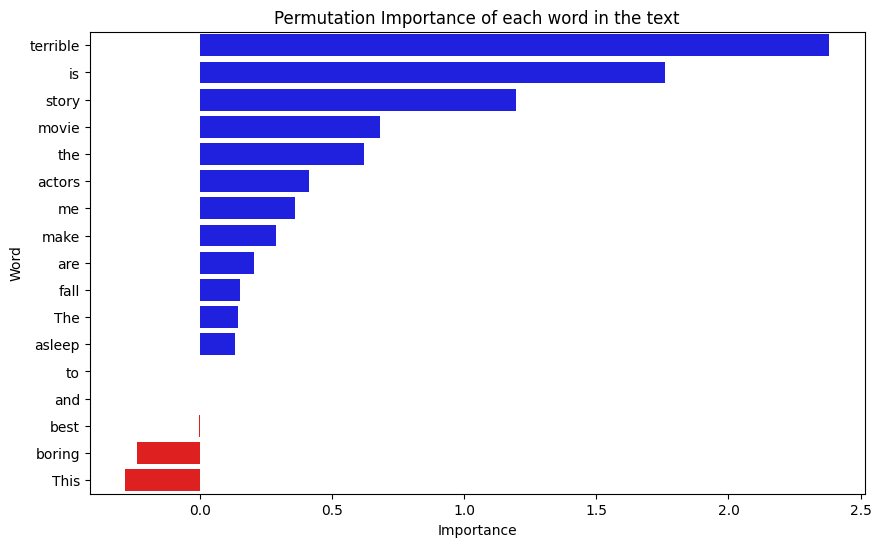

In [13]:
plot_importance(result, "Permutation Importance of each word in the text")

In [14]:
def likelihood_importance(text: str, model: torch.nn.Module, device: torch.device = device) -> dict:
    """
    This function calculates the likelihood importance of each word in the text.
    Instead of changing the order of the words, it will remove one word at a time 
    and calculate the importance.

    Args:
        text: Text to calculate the likelihood importance.
        model: Model to use for the predictions.
        device: Device to use for the predictions.

    Returns:
        A dictionary with the likelihood importance of each word in the text.
    """
    
    # Get the initial class assigned to the text
    original_prediction = predict_single_text(text, model, device, probability=False, likelihood=True)
    
    # Initialize importance dictionary
    importance:dict = {}
    
    # tokenize the text
    tokenized_text: List[str] = tokenize_sentence(text)
    
    # Iterate over each token (word) in the text
    for i, token in enumerate(tqdm(tokenized_text, desc="Calculating likelihood importance")):
        # Create a copy of tokens without the current token
        remaining_tokens = list(tokenized_text)
        remaining_tokens.pop(i)
        
        # Join the remaining tokens back into a text
        remaining_text = ' '.join(remaining_tokens)
        
        # Get the predictions of the remaining text
        remaining_predictions = predict_single_text(remaining_text, model, device, probability=False, likelihood=True)
        
        # Store the importance of removing the current token
        importance[token] = original_prediction - remaining_predictions
        
    return importance

    

In [15]:
# Now we will test the new method with the same text as before.
text = data['text'][2]
print(f"Explaining result for: {text}")
result = likelihood_importance(text, model)
print(result)


c:\Users\pablo\Desktop\IMAT\Tercero\NaturalLanguageProcessing\rnn_explainability\env\lib\site-packages\torch\nn\modules\module.py:1520: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  return forward_call(*args, **kwargs)


Explaining result for: There's a unique place in the pantheon of John Ford films for Wagonmaster, Sergeant Rutledge, and The Sun Shines Bright. It was these three films with no box office names in them that Ford didn't have to tailor the film around the persona of a star being it John Wayne, Henry Fonda, or any of the others he worked with. Not surprising that Ford considered all these as favorites of one kind or another. <br /><br />Ben Johnson and Harry Carey, Jr. a couple of likable cowpokes sign on to guide a Mormon wagon train to a valley in Arizona territory. Along the way they are joined first by a group stranded players from a medicine show and then by a family of outlaws on the run named Clegg. Their stories merge and what happens is the basis of the film's plot.<br /><br />Had Wagonmaster been done even 10 years earlier on the strength of the two performances turned in by Johnson and Carey, both probably would have had substantial careers as B picture cowboys. In the case of 

Calculating likelihood importance:   0%|          | 0/569 [00:00<?, ?it/s]

Calculating likelihood importance: 100%|██████████| 569/569 [00:07<00:00, 78.51it/s]

{'Theres': 0.0, 'a': 0.0, 'unique': 0.0, 'place': 0.0, 'in': 0.005366802215576172, 'the': -0.0173342227935791, 'pantheon': 0.0, 'of': 0.0, 'John': 0.0, 'Ford': -1.1920928955078125e-07, 'films': 0.0, 'for': 0.0, 'Wagonmaster': 0.009742379188537598, 'Sergeant': 0.0, 'Rutledge': 0.0, 'and': 0.0, 'The': 0.0, 'Sun': 0.0, 'Shines': 0.0, 'Bright': 0.0, 'It': 4.410743713378906e-06, 'was': -4.76837158203125e-07, 'these': 0.0, 'three': 0.0, 'with': 4.410743713378906e-06, 'no': -2.86102294921875e-06, 'box': 0.0, 'office': 0.0, 'names': 0.0, 'them': 1.1920928955078125e-06, 'that': -0.00028634071350097656, 'didnt': 0.0, 'have': -1.1920928955078125e-07, 'to': 0.0, 'tailor': 0.0, 'film': 0.2696068286895752, 'around': 0.0, 'persona': 0.0, 'star': 0.0, 'being': -1.1920928955078125e-06, 'it': -2.384185791015625e-07, 'Wayne': 0.0, 'Henry': 0.0, 'Fonda': 0.0, 'or': 0.0, 'any': 0.0, 'others': 0.0, 'he': 3.4570693969726562e-06, 'worked': 1.1920928955078125e-07, 'Not': 0.0, 'surprising': 0.0, 'considered': 0

C:\Users\pablo\AppData\Local\Temp\ipykernel_17664\2793492178.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Word', data=df, palette=colors)


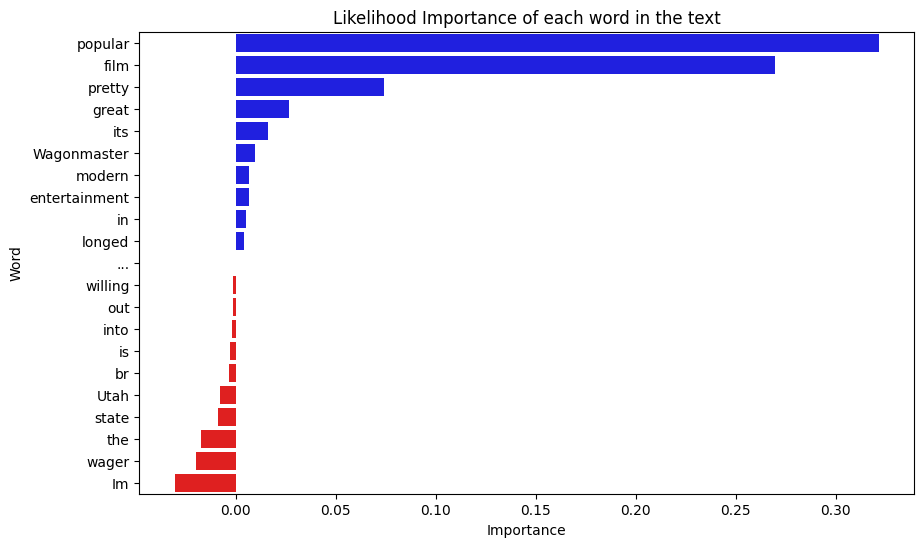

In [16]:
# Now we will plot the results
plot_importance(result, "Likelihood Importance of each word in the text")


In [17]:
# Now we will test the new method with the same text as before.
text = "This movie is the best to make me fall asleep. The actors are boring and the story is terrible."
print(f"Explaining result for: {text}")
result = likelihood_importance(text, model)
print(result)


c:\Users\pablo\Desktop\IMAT\Tercero\NaturalLanguageProcessing\rnn_explainability\env\lib\site-packages\torch\nn\modules\module.py:1520: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  return forward_call(*args, **kwargs)


Explaining result for: This movie is the best to make me fall asleep. The actors are boring and the story is terrible.


Calculating likelihood importance: 100%|██████████| 19/19 [00:00<00:00, 235.49it/s]

{'This': 0.12171554565429688, 'movie': -0.09090867638587952, 'is': -0.07125908136367798, 'the': -0.0184134840965271, 'best': 0.2511288821697235, 'to': 0.0, 'make': -0.009645015001296997, 'me': 0.0049659013748168945, 'fall': -0.051057666540145874, 'asleep': -0.1088407039642334, 'The': 0.06946977972984314, 'actors': 0.01805335283279419, 'are': 0.024305492639541626, 'boring': -0.21136237680912018, 'and': 0.0, 'story': 0.027379900217056274, 'terrible': -0.4129266329109669}


C:\Users\pablo\AppData\Local\Temp\ipykernel_17664\2793492178.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Word', data=df, palette=colors)


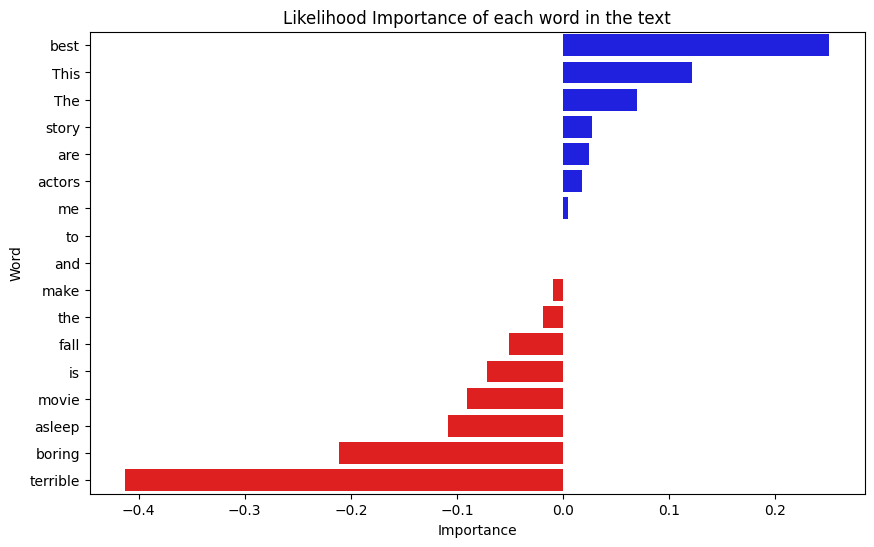

In [18]:
# Now we will plot the results
plot_importance(result, "Likelihood Importance of each word in the text")


In [19]:

def print_colored_text(text: str, importance: dict) -> None:
    """
    Prints the text with each word colored based on its importance.

    Args:
        text: The text to print.
        importance: A dictionary with the importance of each word in the text.
    """
    # Tokenize the text
    tokens = tokenize_sentence(text)
    
    # Iterate over each token (word) in the text
    for token in tokens:
        # Get the importance of the current token
        token_importance = importance.get(token, 0)
        
        # Set the color of the token based on its importance
        color = 'red' if token_importance < 0 else 'blue'
        
        # Print the token with the corresponding color
        print(colored(token, color), end=' ')
        
    print()

print_colored_text(text, result)

This movie is the best to make me fall asleep The actors are boring and the story is terrible 
